# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [15]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from functions import util
import os

In [ ]:
#today = datetime.datetime.now() - datetime.timedelta(0)
#today = datetime.date.today()
today = datetime.datetime.now().replace(hour=0, minute=0, second=0, microsecond=0)
today_str = today.isoformat()  # Convert to ISO 8601 format
tomorrow = today + datetime.timedelta(days = 1)
today_date = datetime.datetime.today().date()  # Get the current date without time
today

datetime.date(2024, 11, 19)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [17]:
os.environ["HOPSWORKS_API_KEY"] = "C4SS8dsi1TSlBcSM.FQPsjTGnxcG3aKFbWq1yzAaBw0jRlpCtRB2l7ESP9MGqHKgjMCRbpjOjbdPzJwLp"

project = hopsworks.login()
fs = project.get_feature_store() 

secrets = util.secrets_api(project.name)
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1163417
Connected. Call `.close()` to terminate connection gracefully.
Connected. Call `.close()` to terminate connection gracefully.


## <span style="color:#ff5f27;"> ⚙️ Feature View Retrieval</span>


In [18]:
feature_view = fs.get_feature_view(
    name='air_quality_fv',
    version=1,
)

## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [19]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=1,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

Connected. Call `.close()` to terminate connection gracefully.


In [20]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='2.619907E0', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [23]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()
batch_data

RestAPIError: Metadata operation error: (url: https://c.app.hopsworks.ai/hopsworks-api/api/project/1163417/featurestores/query). Server response: 
HTTP code: 422, HTTP reason: UNPROCESSABLE_ENTITY, body: b'{"errorCode":120001,"usrMsg":"2024-11-19","errorMsg":"An argument was not provided or it was malformed."}', error code: 120001, error msg: An argument was not provided or it was malformed., user msg: 2024-11-19

In [ ]:
# Get weather data
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()
batch_data

air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)

# Read the data
air_data = air_quality_fg.read()
air_data['date'] = pd.to_datetime(air_data['date']).dt.date  # Strip the time part

# Now filter by today
air_data_today = air_data[air_data['date'] == today_date]
print(air_data_today)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.72s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.23s) 
Empty DataFrame
Columns: [date, pm25, pm25_lag_1, pm25_lag_2, pm25_lag_3, country, city, street, url]
Index: []


In [ ]:
print(air_data)

            date   pm25  pm25_lag_1  pm25_lag_2  pm25_lag_3 country  \
0     2021-06-21   1.40        3.52        3.08        3.87  Sweden   
1     2019-12-27   0.98        0.77        1.35        1.70  Sweden   
2     2020-01-11   2.04        0.85        2.10        3.16  Sweden   
3     2023-02-01   2.06        1.12        1.53        2.20  Sweden   
4     2022-04-03   1.40        1.10        1.00        1.00  Sweden   
...          ...    ...         ...         ...         ...     ...   
1762  2024-11-13  18.00       12.00        6.20        6.07  Sweden   
1763  2024-11-14   6.00       18.00       12.00        6.20  Sweden   
1764  2024-11-15  10.00        6.00       18.00       12.00  Sweden   
1765  2024-11-16   9.00       10.00        6.00       18.00  Sweden   
1766  2024-11-17   2.00        9.00       10.00        6.00  Sweden   

               city      street                                 url  
0     Majorna-Linné  Masthugget  https://api.waqi.info/feed/A60853/  
1     M

In [ ]:
batch_data
batch_data['pm25_lag_1'] = air_data_today['pm25'].values[0]
batch_data['pm25_lag_2'] = air_data_today['pm25_lag_1'].values[0]
batch_data['pm25_lag_3'] = air_data_today['pm25_lag_2'].values[0]

# Ensure batch_data['date'] is a datetime object with no time (convert if needed)
batch_data['date'] = pd.to_datetime(batch_data['date']).dt.date  # Strip time from date


IndexError: index 0 is out of bounds for axis 0 with size 0

### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [ ]:
# Run inference for each day sequentially, starting from the first day
for i in range(len(batch_data)):
    current_day = today_date + datetime.timedelta(days=i+1)  # Current day (start with tomorrow)
    tomorrow = today_date + datetime.timedelta(days=i+2)  # Day after tomorrow
    
    # Filter the data for the current day
    pred_data = batch_data[batch_data['date'] == current_day]
    lag_2 = pred_data['pm25_lag_1'].values[0]
    lag_3 = pred_data['pm25_lag_2'].values[0]

    print(f"Running inference for {current_day}")
    
    # Make the prediction for the current day
    pm25_pred = retrieved_xgboost_model.predict(
        pred_data[['pm25_lag_1', 'pm25_lag_2', 'pm25_lag_3', 'temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']]
    )
    
    # Add the prediction to the 'pm25_pred' column for the current day
    batch_data.loc[batch_data['date'] == current_day, 'predicted_pm25'] = pm25_pred

    batch_data.loc[batch_data['date'] == tomorrow, 'pm25_lag_1'] = pm25_pred  # Today's prediction for tomorrow's lag_1
    batch_data.loc[batch_data['date'] == tomorrow, 'pm25_lag_2'] = lag_2  # Today's lag_1 for tomorrow's lag_2
    batch_data.loc[batch_data['date'] == tomorrow, 'pm25_lag_3'] = lag_3  # Today's lag_2 for tomorrow's lag_3
    print(f"Predicted PM2.5 for {current_day}: {pm25_pred}")

# Show the final predictions and lag columns
print(batch_data[['date', 'predicted_pm25', 'pm25_lag_1', 'pm25_lag_2', 'pm25_lag_3']])


Running inference for 2024-11-17
Predicted PM2.5 for 2024-11-17: [3.5563867]
Running inference for 2024-11-18
Predicted PM2.5 for 2024-11-18: [2.5718112]
Running inference for 2024-11-19
Predicted PM2.5 for 2024-11-19: [3.4099984]
Running inference for 2024-11-20
Predicted PM2.5 for 2024-11-20: [0.81513923]
Running inference for 2024-11-21
Predicted PM2.5 for 2024-11-21: [0.5368627]
Running inference for 2024-11-22
Predicted PM2.5 for 2024-11-22: [1.3326595]
Running inference for 2024-11-23
Predicted PM2.5 for 2024-11-23: [1.4496015]
Running inference for 2024-11-24
Predicted PM2.5 for 2024-11-24: [2.6749728]
Running inference for 2024-11-25
Predicted PM2.5 for 2024-11-25: [4.686455]
         date  predicted_pm25  pm25_lag_1  pm25_lag_2  pm25_lag_3
0  2024-11-18        2.571811    3.556387   10.000000   10.000000
1  2024-11-17        3.556387   10.000000   10.000000    6.000000
2  2024-11-21        0.536863    0.815139    3.409998    2.571811
3  2024-11-20        0.815139    3.409998  

In [ ]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   date                         9 non-null      object 
 1   temperature_2m_mean          9 non-null      float32
 2   precipitation_sum            9 non-null      float32
 3   wind_speed_10m_max           9 non-null      float32
 4   wind_direction_10m_dominant  9 non-null      float32
 5   city                         9 non-null      object 
 6   pm25_lag_1                   9 non-null      float32
 7   pm25_lag_2                   9 non-null      float64
 8   pm25_lag_3                   9 non-null      float64
 9   predicted_pm25               9 non-null      float32
dtypes: float32(6), float64(2), object(2)
memory usage: 632.0+ bytes


### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [ ]:
# Assuming 'batch_data' and 'forecast_date' are already defined
# Ensure 'date' is in datetime format (if it's not already)
batch_data['date'] = pd.to_datetime(batch_data['date'], errors='coerce').dt.date

# Define forecast date as a pandas Timestamp
forecast_date = pd.to_datetime(datetime.date.today())  # This will convert to 'datetime64[ns]'

# Sort the DataFrame by 'date' to ensure it is in ascending order
batch_data = batch_data.sort_values(by=['date'])

# Calculate the 'days_before_forecast_day' based on the difference between each 'date' and the 'forecast_date'
batch_data['days_before_forecast_day'] = (forecast_date - pd.to_datetime(batch_data['date'])).dt.days.abs()

# Assign new columns
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country

# View the updated DataFrame
batch_data



,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_lag_1,pm25_lag_2,pm25_lag_3,predicted_pm25,days_before_forecast_day,street,country
1,2024-11-17,8.30,0.0,29.627363,274.879181,Majorna-Linné,10.000000,10.000000,6.000000,3.556387,1,Masthugget,Sweden
0,2024-11-18,2.75,0.2,5.116561,50.710617,Majorna-Linné,3.556387,10.000000,10.000000,2.571811,2,Masthugget,Sweden
4,2024-11-19,5.15,0.0,7.928177,230.527573,Majorna-Linné,2.571811,3.556387,10.000000,3.409998,3,Masthugget,Sweden
3,2024-11-20,0.75,0.0,26.478973,352.971680,Majorna-Linné,3.409998,2.571811,3.556387,0.815139,4,Masthugget,Sweden
2,2024-11-21,1.35,0.1,18.581022,305.537750,Majorna-Linné,0.815139,3.409998,2.571811,0.536863,5,Masthugget,Sweden
5,2024-11-22,-3.05,0.0,0.804985,153.435013,Majorna-Linné,0.536863,0.815139,3.409998,1.332659,6,Masthugget,Sweden
6,2024-11-23,4.00,0.0,20.880001,270.000000,Majorna-Linné,1.332659,0.536863,0.815139,1.449602,7,Masthugget,Sweden
7,2024-11-24,7.25,0.0,19.386593,211.328629,Majorna-Linné,1.449602,1.332659,0.536863,2.674973,8,Masthugget,Sweden
8,2024-11-25,9.50,0.8,19.813087,182.082520,Majorna-Linné,2.674973,1.449602,1.332659,4.686455,9,Masthugget,Sweden


In [ ]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9 entries, 1 to 8
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   date                         9 non-null      object 
 1   temperature_2m_mean          9 non-null      float32
 2   precipitation_sum            9 non-null      float32
 3   wind_speed_10m_max           9 non-null      float32
 4   wind_direction_10m_dominant  9 non-null      float32
 5   city                         9 non-null      object 
 6   pm25_lag_1                   9 non-null      float32
 7   pm25_lag_2                   9 non-null      float64
 8   pm25_lag_3                   9 non-null      float64
 9   predicted_pm25               9 non-null      float32
 10  days_before_forecast_day     9 non-null      int64  
 11  street                       9 non-null      object 
 12  country                      9 non-null      object 
dtypes: float32(6), float64(2), in

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

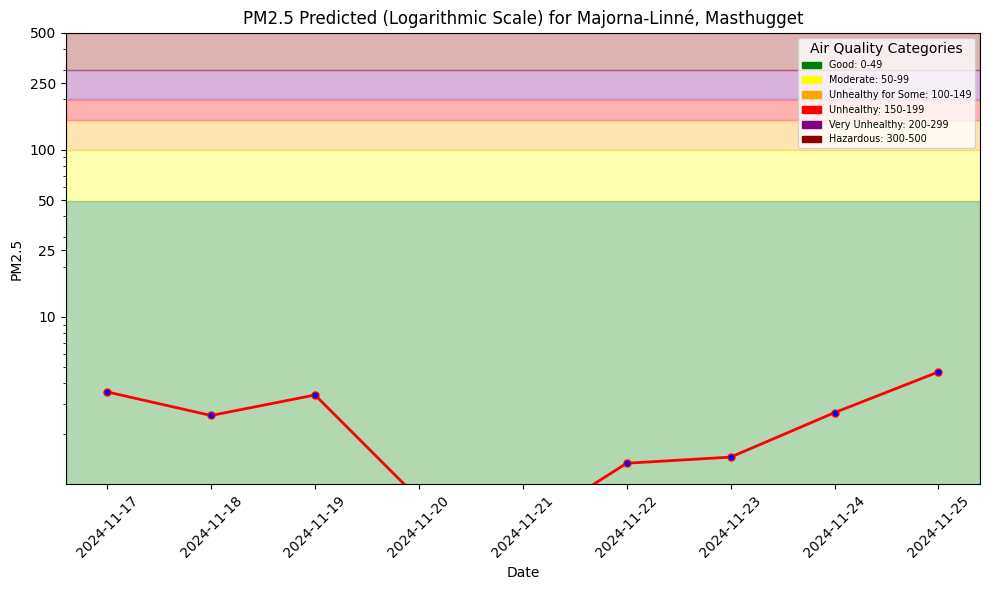

In [ ]:
file_path = "../../docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, file_path)
plt.show()

In [ ]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [ ]:
monitor_fg.insert(batch_data, write_options={"wait_for_job": True})

Uploading Dataframe: 0.00% |          | Rows 0/9 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1163417/jobs/named/aq_predictions_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x175d8dd20>, None)

In [ ]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (4.07s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_lag_1,pm25_lag_2,pm25_lag_3,predicted_pm25,street,country,days_before_forecast_day
0,2024-11-18,7.80,1.1,42.357792,238.201126,Majorna-Linné,3.52499,3.733772,4.236832,4.053681,Masthugget,Sweden,1
1,2024-11-13,8.45,0.0,16.394829,199.230759,Majorna-Linné,12.00000,6.200000,6.070000,9.332541,Masthugget,Sweden,1
2,2024-11-14,6.85,0.0,3.096837,324.462250,Majorna-Linné,20.00000,12.000000,6.200000,7.215687,Masthugget,Sweden,1
3,2024-11-16,7.85,0.7,29.834423,261.674438,Majorna-Linné,9.00000,6.000000,18.000000,3.272138,Masthugget,Sweden,1
4,2024-11-17,8.30,0.0,29.627363,274.879181,Majorna-Linné,10.00000,10.000000,6.000000,3.556387,Masthugget,Sweden,1


In [ ]:
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.39s) 


,date,pm25,pm25_lag_1,pm25_lag_2,pm25_lag_3,country,city,street,url
0,2021-06-21 00:00:00+00:00,1.40,3.52,3.08,3.87,Sweden,Majorna-Linné,Masthugget,https://api.waqi.info/feed/A60853/
1,2019-12-27 00:00:00+00:00,0.98,0.77,1.35,1.70,Sweden,Majorna-Linné,Masthugget,https://api.waqi.info/feed/A60853/
2,2020-01-11 00:00:00+00:00,2.04,0.85,2.10,3.16,Sweden,Majorna-Linné,Masthugget,https://api.waqi.info/feed/A60853/
3,2023-02-01 00:00:00+00:00,2.06,1.12,1.53,2.20,Sweden,Majorna-Linné,Masthugget,https://api.waqi.info/feed/A60853/
4,2022-04-03 00:00:00+00:00,1.40,1.10,1.00,1.00,Sweden,Majorna-Linné,Masthugget,https://api.waqi.info/feed/A60853/
...,...,...,...,...,...,...,...,...,...
1761,2024-11-12 12:31:39.561610+00:00,12.00,6.20,6.07,2.27,Sweden,Majorna-Linné,Masthugget,https://api.waqi.info/feed/A60853/
1762,2024-11-13 00:00:00+00:00,18.00,12.00,6.20,6.07,Sweden,Majorna-Linné,Masthugget,https://api.waqi.info/feed/A60853/
1763,2024-11-14 00:00:00+00:00,6.00,18.00,12.00,6.20,Sweden,Majorna-Linné,Masthugget,https://api.waqi.info/feed/A60853/
1764,2024-11-15 00:00:00+00:00,10.00,6.00,18.00,12.00,Sweden,Majorna-Linné,Masthugget,https://api.waqi.info/feed/A60853/


In [ ]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

print(outcome_df, 'outcome_df')
print(preds_df, 'preds_df')

# Convert 'date' columns to datetime, removing any time zone info if necessary
outcome_df['date'] = pd.to_datetime(outcome_df['date']).dt.tz_localize(None)  # Remove timezone if present
preds_df['date'] = pd.to_datetime(preds_df['date']).dt.tz_localize(None)  # Remove timezone if present

# Now merge the DataFrames
hindcast_df = pd.merge(preds_df, outcome_df, on="date")

# View the resulting DataFrame
print(hindcast_df)

hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
#if len(hindcast_df) == 0:
    #hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

                                 date   pm25
0           2021-06-21 00:00:00+00:00   1.40
1           2019-12-27 00:00:00+00:00   0.98
2           2020-01-11 00:00:00+00:00   2.04
3           2023-02-01 00:00:00+00:00   2.06
4           2022-04-03 00:00:00+00:00   1.40
...                               ...    ...
1761 2024-11-12 12:31:39.561610+00:00  12.00
1762        2024-11-13 00:00:00+00:00  18.00
1763        2024-11-14 00:00:00+00:00   6.00
1764        2024-11-15 00:00:00+00:00  10.00
1765        2024-11-16 00:00:00+00:00   9.00

[1766 rows x 2 columns] outcome_df
         date  predicted_pm25
0  2024-11-18        4.053681
1  2024-11-13        9.332541
2  2024-11-14        7.215687
3  2024-11-16        3.272138
4  2024-11-17        3.556387 preds_df
2024-11-16 17:11:38,692 WARNING: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

,date,predicted_pm25,pm25
0,2024-11-13,9.332541,18.0
1,2024-11-14,7.215687,6.0
2,2024-11-16,3.272138,9.0


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

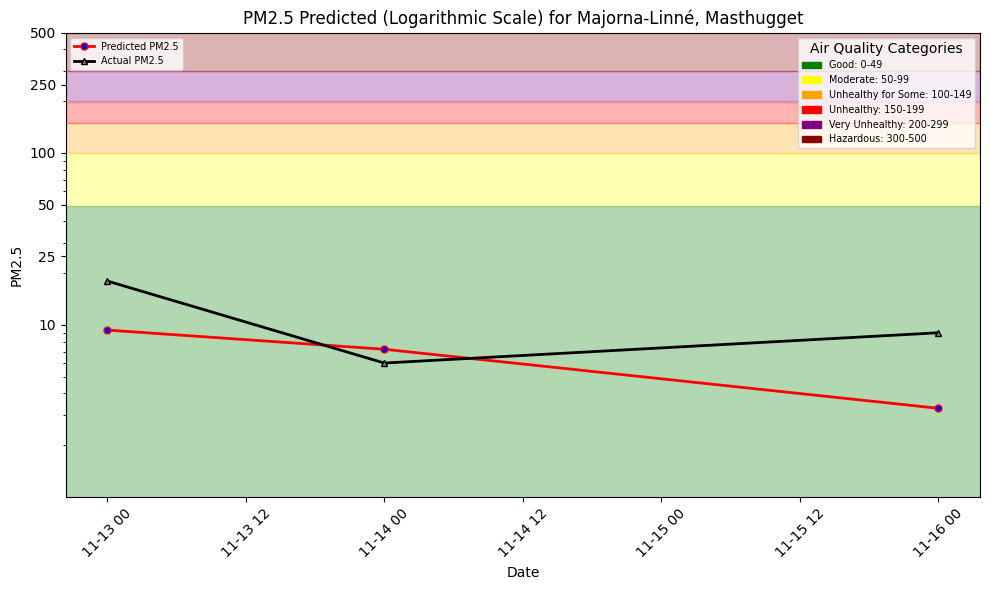

In [ ]:
file_path = "../../docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, file_path, hindcast=True)
plt.show()

---